In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import warnings 
warnings.filterwarnings('ignore')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

E:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

Num GPUs Available:  1


# Read Data

In [2]:
train_data = pd.read_csv('dataset/train_data.csv', sep=';').dropna()
test_data = pd.read_csv('dataset/test_data.csv', sep=';').dropna()

train_data.columns = ['1','Time', 'Bytes', 'Packages']
test_data.columns = ['1','Time', 'Bytes', 'Packages']
print('train_shape: ',train_data.shape)
print('test_shape: ',test_data.shape)


train_shape:  (242391, 4)
test_shape:  (103907, 4)


# LOAD MODEL

In [3]:
# Восстановим в точности ту же модель, включая веса и оптимизатор
model = tf.keras.models.load_model("ouput.h5")

# Покажем архитектуру модели
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          multiple                  0         
_________________________________________________________________
dense_40 (Dense)             multiple                  3328      
_________________________________________________________________
dense_41 (Dense)             multiple                  514       
Total params: 3,842
Trainable params: 3,842
Non-trainable params: 0
_________________________________________________________________


# Parametrs

In [4]:
timeDelta = 3600
LAST_COUNT = 6

# CLEAR DATA FROM EMISSIONS

In [5]:
def clearData(dataset):
    ind_missing = train_data[train_data['Bytes'] > 1039828].index
    while len(ind_missing) != 0:
        for index in ind_missing:
            mean = (train_data["Bytes"][index - 1] + train_data["Bytes"][index + 1]) / 2
            train_data["Bytes"][index] = mean
        ind_missing = train_data[train_data['Bytes'] > 1039828].index
        
    ind_missing = train_data[train_data['Packages'] > 2000].index
    while len(ind_missing) != 0:
        for index in ind_missing:
            mean = (train_data["Packages"][index - 1] + train_data["Packages"][index + 1]) / 2
            train_data["Packages"][index] = mean
        ind_missing = train_data[train_data['Packages'] > 2000].index
    return dataset



In [6]:
train_data = clearData(train_data)
test_data = clearData(test_data)

# Generate Dataset

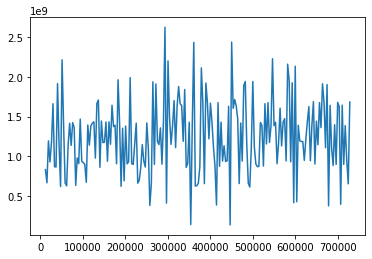

In [7]:
def findIndexWhereNextTime(startIndex, data, timeDelta):
    startIndex += 1
    startTime = data[startIndex][1]
    # Чтобы примерно попадать в интервал
    offset = 50
    for index in range(startIndex, len(data)):
        time = data[index][1]
        
        if (startTime + timeDelta) == time:
            return index
        
        if time > (startTime + timeDelta - offset) and (time < (startTime + timeDelta + offset)):
            return index
        
        if timeDelta < (time - data[index - 1][1]):
            return index
    
    return None
        
def generateDatasetWithSumElements(dataset):
    dataset = dataset.values
    newDataset = []
    
    # current index 
    currentIndex = 0
    time = dataset[currentIndex][1]
    findNextIndex = findIndexWhereNextTime(currentIndex, dataset, timeDelta)
    
    while findNextIndex != None:
        newBytes = dataset[currentIndex: findNextIndex][:,2].sum()
        newPackages = dataset[currentIndex: findNextIndex][:,3].sum()
        newDataset.append([time, newBytes, newPackages])
        
        currentIndex = findNextIndex
        time = dataset[currentIndex][1]
        findNextIndex = findIndexWhereNextTime(currentIndex, dataset, timeDelta)
#         print("Current Index ", currentIndex, " Next ", findNextIndex)
    return newDataset

def generateDataset(dataset):
    x_train = []
    y_train = []
    
    size = len(dataset) - LAST_COUNT - 1
    for index in range(0, size):
        x_train.append(list(dataset[index: index + LAST_COUNT]))
        y_train.append(dataset[index + LAST_COUNT])
    return (np.array(x_train), np.array(y_train))

# Train Dataset
train_dataset = np.array(generateDatasetWithSumElements(train_data))
train_dataset = np.delete(train_dataset,0,1)
n = len(train_dataset)
train_data = pd.DataFrame(train_dataset[0:int(n*0.7)], columns=[ 'Bytes', 'Packages'])

# Test Dataset
test_dataset = np.array(generateDatasetWithSumElements(test_data))
plt.plot(test_dataset[:,0], test_dataset[:,1])
test_dataset = pd.DataFrame(np.delete(test_dataset,0,1), columns=[ 'Bytes', 'Packages'])


# Normalize Dataset 

In [8]:
from sklearn.preprocessing import MaxAbsScaler

# create an abs_scaler object
abs_scaler = MaxAbsScaler()

# calculate the maximum absolute value for scaling the data using the fit method
abs_scaler.fit(train_data)

# the maximum absolute values calculated by the fit method
abs_scaler.max_abs_
# array([4.0e+05, 1.7e+01])

# transform the data using the parameters calculated by the fit method (the maximum absolute values)
train_scaled_data = abs_scaler.transform(train_data)

# store the results in a data frame
normalizedTrain = pd.DataFrame(train_scaled_data, columns=train_data.columns)

# visualize the data frame
print("train shape =", normalizedTrain.shape)

# transform the data using the parameters calculated by the fit method (the maximum absolute values)
test_scaled_data = abs_scaler.transform(test_dataset)

# store the results in a data frame
normalizedTest = pd.DataFrame(test_scaled_data, columns=test_dataset.columns)

# visualize the data frame
print("test shape =", normalizedTest.shape)
X_test, y_test = generateDataset(normalizedTest.values)

train shape = (141, 2)
test shape = (202, 2)


# Graphics for predicted

# Предсказывание следующих по предыдущим предсказанным
## Есть первые LAST_COUNT значений, необходимо предсказать на следующие N часов

In [9]:
N = LAST_COUNT * 5
X_predicated = [X_test[0]]
Y_predicated = []

X_true = X_test[0:N]
Y_true = y_test[0:N]

In [11]:
from tensorflow.python.keras import losses
#Здесь по предыдущим значениям получаем следующие
for index in range(0, N - 1 ):
    predicated_val = model.predict(X_test[index:index+1])
    X_predicated.append(np.append(X_predicated[index][1:LAST_COUNT],predicated_val, axis=0))
    Y_predicated.append(predicated_val[0])
    
X_predicated = np.array(X_predicated)
Y_predicated = np.array(Y_predicated)

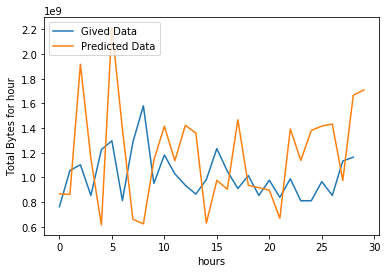

In [12]:
# Diagram Bytes
inversed_predicted = abs_scaler.inverse_transform(Y_predicated)
inversed_true = abs_scaler.inverse_transform(Y_true)

f, ax = plt.subplots(1)
ax.plot(inversed_predicted[:,0], label='Gived Data')
ax.plot(inversed_true[:,0], label='Predicted Data')
ax.legend(loc='upper left')
ax.set_ylabel('Total Bytes for hour')
ax.set_xlabel('hours')
plt.show(f)